In [1]:
#Install Required Libraries
#!pip install PyPDF2 spacy pandas numpy matplotlib seaborn scikit-learn sentence-transformers pytesseract pdf2image

# Install the SpaCy model
#!python -m spacy download en_core_web_sm
#!pip install wordcloud nltk

# Download WordNet data
#import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [2]:
import numpy as np
import pandas as pd
import os
import PyPDF2
import pytesseract
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from collections import defaultdict

### 1. Data Cleaning and Preparation

In [10]:
# Load metadata
metadata = pd.read_csv('/workspaces/project-2-ombudsman/metadata.csv')

# Set the directories
base_folders = [
    #'/workspaces/project-2-ombudsman/12_23_insurance',
    #'/workspaces/project-2-ombudsman/01_24_insurance',
    #'/workspaces/project-2-ombudsman/02_24_insurance',
    #'/workspaces/project-2-ombudsman/03_24_insurance',
    #'/workspaces/project-2-ombudsman/04_24_insurance',
    '/workspaces/project-2-ombudsman/05_24_insurance'
]

**Exclude words**

In [11]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to get synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name().replace('_', ' ').lower())
    return synonyms

# Function to create synonym mapping for a list of words
def create_synonym_mapping(words):
    mapping = {}
    for word in words:
        synonyms = get_synonyms(word)
        representative = word  # You could also select the most common or central synonym
        for synonym in synonyms:
            mapping[synonym] = representative
    return mapping

# Generate synonym mapping for commonly important words in the domain
important_words = [
            'recommendation', 'tax', 'impact', 'investment', 'commercial', 'document', 'transparent', 'circumtance'
]

synonym_mapping = create_synonym_mapping(important_words)

# Expanded custom stop words list
text_exclude = set([
    "aa", "d", "g",
    "able", "account", "act", "action", "accept", "add", "address", "after","agree", "appear", "appeared", "apply", 
    "appreciate", "april", "august", "arrange", "are", "ask", "august", "available", 
    "base", "basis", "be", "been", "before", "begin", "believe", "behalf", "buy",
    "can", "case", "carry", "cause", "claim", "complain", "complains", "complaint", "complained","comment", "company", 
    "conclude", "conclusion", "concern", "consider", "continue", "could", "cost", "customer",
    "date", "day", "decide", "decision","decrease", "deduct", "december", "discuss", "direct", "does", "did", 
    "europe","event", "evidence","explain", "example", "existing", "end",
    "feel", "felt", "february", "final", "find", "finding", "first", "follow", "fully",
    "gave", "get", "give", "go", "going", "got", 
    "handle", "happen", "happened", "had", "has", "have", "hm","hours", "how", 
    "incident", "include", "increase", "indicate","initial", "insurance", "investigate", "investigator", "i.e.", "is", "issue", "item", 
    "january", "july", "june", "know", "knew", "later", "lead", "list", "like", "line", "likely", "limited", "Limited", "ltd", "Ltd", "look", "looked", 
    "main", "make", "made", "march", "matter", "may", "mean", "might", "minutes", "month", 
    "need", "new", "not uphold", "note", "november", "number", "october", "ombudsman", "overall",
    "ph", "photo", "perhaps", "policy", "place", "point", "position", "pre", "previous","prior", "provisional", "provide", "put", "question", 
    "reason", "receive", "record", "refer", "remain", "report", "request", "require", "result", "return", "right", 
    "sa","said", "saw", "say", "see", "second", "section", "seen", "send", "set", "september", 
    "shall", "should", "show", "simple","sorry","start", "summary", "sun",
    "take", "tell", "third","thing", "think", "thought", "time", "to", "told", "total", "took", "turn", "try",
    "uk","uphold","unable",  "use", "usually", "ultimately","vitality",
    "want", "way", "was", "went", "were", "week",
    "what", "when", "where", "which", "whilst", "why", "will", "work", "would", 
    "year"
])

complain_exclude = set([
    "ltd", "limited", "insurance", "services", "company", "plc", "uk", "group", "corporation", "assurance", 
    "association", "international", "general", "financial", "national", "union", 
    "mutual", "europe", "europe", "sa/nv", "se", "year", "month", "day",
    "january", "february", "march","april","may","june","july","august","september","october","november","december",
    "claim", "policy", "complain", "complains",  "complaint", "complained", "ph", "sa"
])

# Function to clean and replace synonyms in text
def clean_text_with_synonyms(text, synonym_mapping, excl_words ):
    doc = nlp(text)
    tokens = [
        synonym_mapping.get(token.lemma_.lower(), token.lemma_.lower())
        for token in doc
        if len(token.text) > 1
        and not token.is_stop and not token.is_punct
        and not any(char.isdigit() for char in token.text)
        and not re.match(r'^(Mr|Mrs|Miss|Ms)\.?', token.text)
        and token.lemma_.lower() not in excl_words
    ]
    return ' '.join(tokens)

**Extract the main complaint reason**

In [12]:
# Function to extract text from "The complaint" section
def extract_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    match = pattern.search(text)
    if match:
        return match.group(0)
    return None

# Function to extract main reason for the complaint
def extract_main_reason(text):
    doc = nlp(text)
    complaint_phrase = ""
    # Look for patterns indicating dissatisfaction
    for sent in doc.sents:
        if any(keyword in sent.text.lower() for keyword in ["complain", "complained", "complains", 
                                                            "unhappy", "disappointed", "not satisfied", "not happy", 
                                                            "dissatisfied", "dissatisfaction", "frustrated", "frustration"]):
            complaint_phrase = sent
            break

    # Extract the main reason in up to 30 words
    main_reason = []
    found_complaint = False
    for token in complaint_phrase:
        # Look for the pattern indicating the complaint reason
        if found_complaint:
            if token.dep_ in ("amod", "acomp", "attr", "dobj", "pobj", "advmod", "ROOT", "poss", "nsubj", "prep", "conj") and token.text.lower() not in {"complain",
                                                                                                    "unhappy", "disappointed", "that", "about"}:
                main_reason.append(token.text)
            if len(main_reason) >= 30:
                break
        if any(keyword in token.lemma_.lower() for keyword in ["complain", "complained", "complains", "feels",
                                                               "unhappy", "disappoint", "not happy", "not satisfied", "dissatisfied", "frustrated"]):
            found_complaint = True

    return ' '.join(main_reason[:30])

# Function to remove "The complaint" section from text
def remove_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    return pattern.sub('', text)

**Extract Compensation Amount**

In [13]:
# Function to extract compensation amount from "My final decision" or "Putting things right" sections
def extract_compensation(text):
    patterns = [
        re.compile(r'My final decision.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL),
        re.compile(r'Putting things right.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL)
    ]
    for pattern in patterns:
        match = pattern.search(text)
        if match:
            return match.group(1)
    return None

# Function to remove "My final decision" and "Putting things right" sections from text
def remove_final_decision_section(text):
    patterns = [
        re.compile(r'My final decision.*', re.DOTALL),
        re.compile(r'Putting things right.*', re.DOTALL)
    ]
    for pattern in patterns:
        text = pattern.sub('', text)
    return text

**Standardise company name and remove company name from the feature text**

In [14]:
# List of company names to remove
company_names = [
    "UKI", "AIA", "AIG", "247 Home Assist", "A plan holdings", "AA Underwriting", "Abacus", "Abbey", "Abbeyfields",
    "Acasta European", "Accelerant", "Accredited", "Acorn", "Acromas", "Action 365", "ActiveQuote", "ACUITY PROFESSIONAL ADVISERS",
    "Admiral", "Adrian Flux", "Advance", "Advance Mortgage", "Advantage", "Advisory", "Aetna", "Affinity", "Ageas", "Ageas Retail",
    "Agency Management Network", "Agria Pet", "AIG Life", "Aioi Nissay Dowa", "Alan Boswell", "Albany Park", "AllClear", 
    "Allianz Business", "Allianz Global Corporate", "Allianz", "Allied World Assurance", "Alwyn", "American Express",
    "American International Group", "Amicus", "Amtrust Europe", "Amtrust International", "Ancile", "Andrew Smith",
    "Animal Friends", "Aon", "Apex", "Apple Retail", "ARAG Allgemeine Versicherungs", "Arc Legal Assistance", "Arch", "Argos",
    "Arthur J. Gallagher", "Aspen", "Aspray", "Assicurazioni Generali", "Assurant Direct", "Assurant General", "Assured Futures",
    "Aston Lark", "Astrenska", "Asurion Europe", "ATLANTA 1", "Atlanta Insurance Intermediaries", "Atlas", "Automobile Association",
    "AutoProtect", "Avantia", "Aviva Health", "Aviva", "Aviva Life & Pensions", "Avon", "AWP P&C", "AXA Assistance", "AXA France IARD",
    "AXA Health", "AXA", "AXA PPP Healthcare", "AXA XL", "AXIS Specialty Europe", "Balens", "Bank of Scotland", "Bapchild Motoring World",
    "Barclays Bank", "Bartholomew & James", "Bastion", "BCR Legal Group", "Bennetts Motorcycling", "Berkshire Hathaway International",
    "Best Protect Online", "BISL", "Blue Badge Mobility", "BQI Group", "Bradford & Bingley", "Brightside", "British Friendly Society",
    "British Gas", "Broker Direct", "Broker Experts", "Brooklin Claims Consultants", "Bryan James & Co", "Building Block", "Bulstrad Life Vienna",
    "BUPA", "Business Insurance Solutions", "Butterworth Spengler Commercial", "Calpe", "Cambrian Associates", "Canada Life",
    "Capital One (Europe)", "Car Care Plan", "Card Protection Plan", "Carole Nash", "Carrot Risk Technologies", "CASLP", "Caspian Assured",
    "Castle Financial & Mortgage", "Casualty & General", "Cavendish Munro Professional Risks", "Cavendish Online", "Chalfont Investment Consultants",
    "Chaucer", "China Taiping", "Chubb European Group", "Cia", "Cigna Europe", "CIGNA Europe", "CIGNA Life", "CIP Brokers", "Cirencester Friendly Society",
    "City And Commercial", "Clear Insurance Management", "Clegg Gifford & Co", "Clements Europe", "Click2protect", "Close Asset Management",
    "Cogent", "Collingwood", "Collinson", "Compare The Market", "Complete Cover Group", "ComplianceTrak", "Connells", "Convex",
    "Co-op", "Cornish Mutual Assurance", "Countrywide Assured", "Countrywide Principal", "County Consultants", "Covea", "Coversure",
    "Coverwise", "Cowen", "Currys Group", "Cuvva", "DAS Legal Expenses", "Davies Craddock", "DAVIES MGA", "Deal Direct Financial Solutions",
    "Denis O Brown & Associates", "Devitt", "Domestic & General", "Dynamo Cover", "Ecclesiastical", "ERGO Reiseversicherung", "ERGO TRAVEL",
    "ERGO Versicherung", "Eridge Underwriting Agency", "Essential Finance Group Management", "esure", "Esure", "ETU Forsikring", "EUI",
    "Euler Hermes", "Euroins", "Europ Assistance", "Evolution", "Exchequer Risk Management", "Exeter Friendly Society", "Express Finance Corporation",
    "Extracover", "Fairmead", "Falcon Underwriting", "Finance Advice Group", "FinanceMe", "Financial & Legal", "Finch Commercial", "First Central Management",
    "First Central Underwriting", "First Complete", "First Title", "Fish Administration", "FMB", "FMG Support (FIM)", "Folgate", "Ford Retail",
    "Forsakringsaktiebolaget Agria", "Fortegra Europe", "Fox Private Finance", "Freeway UK", "Friends Capital", "Furniture Village", "Genistar",
    "Global Re Broking Solutions", "Goldcrest Ins", "Got You Covered", "Granite Finance", "Great Lakes", "Gresham", "Group 1 Automotive", "Grove & Dean",
    "H. W. Wood", "Halifax General", "Harris Balcombe", "Hastings", "Haven", "Hayburn Rock Financial Planning", "HCC International", "HDI Global",
    "Health and Protection", "Health Shield Friendly Society", "HEALTHCARE CLARITY", "Healthy Pets", "Heath Crawford", "Hedgehog", "Helvetia Global Solutions",
    "Herts Consultants", "HFIS", "Highway", "Higos", "Hiscox", "Hiscox Underwriting", "HMCA", "HMCA/S", "Holiday Extras Cover", "Homepro", "Homeserve Membership",
    "Hood Group", "Howden Employee Benefits & Wellbeing", "Howden Brokers","HSBC", "HSB Engineering", "HSBC Life", "HSBC Bank", "Hubener Versicherungs", "Hugh J. Boswell",
    "Hyperformance", "I Go 4", "I.M.S. (London)", "Impact Services (Bolton)", "Independent Health Care Solutions", "Inspop.com", "Claims Centre", "Insurance Factory",
    "Insure & Go", "INSURE GROUP", "Intelligent Advisory", "Inter Partner Assistance", "IPA SA", "International General", "IPP Financial Services", "Irwell", "ITC Compliance",
    "JCT600 (Yorkshire)", "Jelf Brokers", "Jigsaw", "John Henshall", "John Lewis", "John Robert Cox", "Kent and Sussex Financial Group", "Kerland Pitman", "KGM Underwriting",
    "Kingsbridge Risk Solutions", "Kingsway", "Kingswood Brokers", "Konsileo (Trading)", "L J J Associates", "Lakes Mortgages", "Legal and General Assurance Society",
    "Liberty Mutual", "Liberty Seguros", "Lifesearch Partners", "Lifetime Protection", "Lighthouse Advisory", "Liverpool Victoria Financial", "Liverpool Victoria",
    "Lloyd & Whyte Community Broking", "Lloyd & Whyte", "Lloyd", "Lloyds", "Lloyds Bank General", "Lloyds Bank", "Lloyd's", "Lockton Companies", "London and Country Mortgages", "London General",
    "Loyal", "LV", "M & D H", "M & N Service", "Magus Private Wealth", "Makesure", "ManyPets", "Mapfre Asistencia", "Markel International", "Markerstudy", "Marsh", "Marshall Motor",
    "Marshmallow Financial", "Marshmallow", "MBNA", "MCE", "McMorrow Murphy", "Medicash Health Benefits", "Mercedes-Benz Services", "Mercedes-Benz Retail", "Mercer", "MetLife Europe",
    "Michael Howard", "Mid Cornwall Brokers", "Midway", "Moneysupermarket.com Financial Group", "Monument Life", "Morgan Clark", "Mortgage Advice Bureau (Derby)", "Mortgage Advice Bureau",
    "Mortgage Connect (N.I)", "Morton Michel", "MotoNovo Finance", "Motor Gap", "Motorplus", "Motorpoint", "Motors", "MS Amlin", "Mudhut Property", "Mulsanne", "My Policy",
    "National Deposit Friendly Society", "National House-Building Council", "National Westminster Bank", "Nationwide Building Society", "Neilson Financial", "Nelson", "Newline", 
    "Next Risk Solutions", "Oakleafe Group", "Ocaso", "One Broker (Norwich)", "One Call", "One Insurance", "One Sure", "Openwork", "OVO (S) HOME", "P J Hayman & Company", "Paymentshield",
    "PEBBLE PROTECTION", "Pendragon Finance", "Peninsula Business", "People's Administration", "Personal Assurance", "Personal Touch", "Pet Protect", "Phoenix Life Assurance", "Phoenix Life",
    "PIB Risk", "Pinnacle", "Plum Underwriting", "POLICY EXCESS INSURE", "PolicyBee", "Policywave", "Post Office Management", "Premier Centre", "Premier", "Premier Plus", "Premier Underwriting",
    "Premium Choice", "Premium Credit", "Protector UK", "Pukka Insure", "QBE Europe", "QBE UK", "QIC Europe", "Qmetric Group", "Quilter Financial", "Quilter Mortgage Planning", "Quilter Wealth",
    "RAC Financial", "RAC", "Ramasis", "Reach Financial", "ReAssure Life", "ReAssure", "Reassured", "Red Sands", "Rentokil", "Revolut Travel", "Richmond Cars (Botley)", "Right Choice Brokers", 
    "Right to Health", "Ringsite", "Riverdale Business", "RiverStone", "Rock Services", "Royal & Sun Alliance","RSA", "S & L Healthcare", "Sabre", "Safe World", "Saga", "Sainsbury's Bank", 
    "Santander", "Sainsbury", "Scottish Equitable", "Scottish Friendly Assurance", "Scottish Widows", "SEIB BROKERS", "Sennocke International", "Sesame", "Simplyhealth Access", "Skyfire", "Society of Lloyd's",
    "Somerset Bridge Services", "Soteria", "St Andrew's", "St Giles and Finance", "St James's Place", "ST&R", "Starr International (Europe)", "Stonebridge International", "Stride",
    "Sun Life Assurance Company of Canada", "Sure Wise", "Suttons Independent Advisers", "Switch Health", "T&R Direct", "Taylormade Finance", "TBO", "Tedaisy Underwriting", 
    "Telefonica Seguros y Reaseguros", "Telefonica", "Telford-Reede", "Tempcover", "Tesco Mobile", "Tesco Personal Finance", "Tesco Underwriting", "Thamesbank", "Thatched Owners", 
    "The Ancient Order of Foresters Friendly", "The Baptist", "The Baxendale", "The Clear Health", "The Co-operative Bank", "The Equine and Livestock", "The National Farmers' Union Mutual",
    "The New India Assurance", "The Original Holloway Friendly", "The Plan Group", "The Prudential Assurance", "The Right Mortgage", "The Royal Bank of Scotland", "Royal London", 
    "The Salvation Army General", "The Shepherds Friendly", "Think Brokers", "Thistle Brokers", "Thomas Carroll (Brokers)", "TICORP", "Tokio Marine Kiln", "Tower Brokers", "Toyota (GB)",
    "Toyota Management", "Tradex", "Travel Facilities", "Travelers", "Tremellen Jeffrey Allan", "Trinity", "Trinity Lane", "U Drive Cover", "U K", "UIA", "Uinsure Commercial", "Uinsure", 
    "UK General", "Union Reiseversicherung", "Unique", "UNUM", "Urban Jungle", "Usay Business", "Utmost Life and Pensions", "V. Woodcock And", "Vantage IB", "Vitality Corporate", 
    "Vitality Health", "Vitality Life", "Vodafone", "Volkswagen Versicherung", "Voyager", "W Denis Brokers", "W E Bedford (Wimbledon)", "W Todd & Son", "Wakam", "Waltons Brokers", 
    "Warranty Management", "Warranty", "Watches of Switzerland", "Watford", "WDP", "Well Dunn", "Wesleyan Assurance Society", "West Bay", "Western Provident", "Westfield Contributory",
    "White Horse Ireland", "White Rose Solutions", "Whitefield Services", "William Russell", "Wilson", "Wise One", "Wrisk Transfer", "Xbridge", "Yachtline", "Yoga", "Zurich Assurance", 
    "Zurich"
]
# Function to standardize company name with standard abbreviations
def standardize_company_name(company):
    # List of words to remove
    words_to_remove = ["Ltd", "ltd", "limited", "Limited", "Insurance", "Services", "Company", "Plc", "UK", "U.K.", "Group", "Corporation", "Assurance", 
                       "Association", "International", "General", "Financial", "National", "Union", 
                       "Mutual", "Europe", "Europe SA/NV", "Europe SA", "Europe NV", "Europe SE", "dac", "SE", "NV"]

    # Standard abbreviations mapping
    abbreviations = {
        "AXA Insurance UK Plc": "AXA",
        "Zurich Insurance Plc": "Zurich",
        "Allianz Insurance Plc": "Allianz",
        "LV Insurance": "LV=",
        "Direct Line Insurance Group Plc": "Direct Line",
        "Legal & General Insurance": "Legal & General",
        "HSBC Insurance": "HSBC",
        "Barclays Insurance": "Barclays",
        "Lloyds Bank Insurance": "Lloyds Bank",
        "Santander Insurance": "Santander",
        "Nationwide Insurance": "Nationwide",
        "Saga Insurance": "Saga",
        "Co-op Insurance": "Co-op",
        "Covea Insurance": "Covea",
        "Chubb Insurance": "Chubb",
        "Markerstudy Insurance": "Markerstudy",
        "Churchill Insurance": "Churchill",
        "Swinton Insurance": "Swinton",
        "Tesco Bank Insurance": "Tesco Bank",
        "Virgin Money Insurance": "Virgin Money",
        "John Lewis Insurance": "John Lewis",
        "Sainsbury's Insurance": "Sainsbury",
        "Royal & Sun Alliance Insurance" : "RSA",
        # Add other standard abbreviations as needed
    }

    # Remove the words_to_remove from the company name
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    standardized_name = pattern.sub('', company).strip()
    
    # Apply abbreviations
    if standardized_name in abbreviations:
        standardized_name = abbreviations[standardized_name]
    
    return standardized_name

# Remove company names from text
def remove_company_names(text, company_names):
    for company in company_names:
        company_standardized = standardize_company_name(company)
        text = re.sub(re.escape(company_standardized), '', text, flags=re.IGNORECASE)
    return text

#### 2. Natural Language Processing for Data Extraction: 

Textual data needs to be further
analysed to extract relevant information from each document, the data extracted can be
used as features for a downstream modelling task.

In [15]:
# Function to extract text with PyPDF2
def extract_text_with_pypdf2(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page_text = reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Failed to extract text from {file_path} using PyPDF2: {e}")
    return text

# Function to process a single PDF file and extract compensation, synonyms group, and then extract main complaint reason
def process_pdf(file_path):
    text = extract_text_with_pypdf2(file_path)

    compensation = extract_compensation(text)
    complaint_section = extract_complaint_section(text)
    
    main_reason = extract_main_reason(complaint_section) if complaint_section else None
    main_reason = clean_text_with_synonyms(main_reason, synonym_mapping, complain_exclude) if main_reason else None

    
    text2 = remove_final_decision_section(text)
    text2 = remove_complaint_section(text2)

    clean_comp = remove_company_names(text2, company_names)
    cleaned_text = clean_text_with_synonyms(clean_comp, synonym_mapping, text_exclude)

    return text2, complaint_section, cleaned_text, main_reason, compensation

In [16]:
# Function to get metadata info
def get_metadata_info(filename):
    decision_id = re.search(r'DRN-(\d+)', filename).group(1)
    row = metadata[metadata['decision_id'].str.contains(decision_id)]
    if not row.empty:
        decision = row.iloc[0]['decision']
        company = row.iloc[0]['company']
        return decision, company
    else:
        return None, None

In [17]:
# Extract text from all PDFs in specified directories
def extract_text_from_pdfs(base_folders):
    pdf_texts = {}
    for base_folder in base_folders:
        for root, dirs, files in os.walk(base_folder):
            for filename in files:
                if filename.endswith('.pdf'):
                    file_path = os.path.join(root, filename)
                    text2, complaint_section, cleaned_text, main_reason, compensation = process_pdf(file_path)
                    pdf_texts[filename] = (text2, complaint_section, cleaned_text, main_reason, compensation)
                    print(f"Processed {filename} -> Main reason: {main_reason}, Compensation: {compensation}")  # Debug print
    return pdf_texts

# Extract text from all PDFs
pdf_texts = extract_text_from_pdfs(base_folders)

# Create dataframe with cleaned texts and corresponding metadata
data = []
for filename, (text2,complaint_section, cleaned_text, main_reason, compensation) in pdf_texts.items():
    decision, company = get_metadata_info(filename)
    if decision and company:
        company = standardize_company_name(company)
        data.append((filename, text2,complaint_section, cleaned_text, decision, company, main_reason, compensation))

df = pd.DataFrame(data, columns=['filename', 'text2','complaint_section', 'cleaned_text', 'decision', 'company', 'main_reason', 'compensation'])

# Remove blank brackets () from company names
df['company'] = df['company'].str.replace(r'\(\s*\)', '', regex=True).str.strip()

df.head()

Processed 05_24_Insurance_DRN-4742637.pdf -> Main reason: legal, Compensation: None
Processed 05_24_Insurance_DRN-4799770.pdf -> Main reason: ad handling, Compensation: None
Processed 05_24_Insurance_DRN-4765620.pdf -> Main reason: trading unfairly payment agree date, Compensation: None


Processed 05_24_Insurance_DRN-4676443.pdf -> Main reason: handle, Compensation: None
Processed 05_24_Insurance_DRN-4745742.pdf -> Main reason: damage discount, Compensation: £100
Processed 05_24_Insurance_DRN-4716398.pdf -> Main reason: satisfactory repair car, Compensation: None
Processed 05_24_Insurance_DRN-4782302.pdf -> Main reason: service relation, Compensation: £200
Processed 05_24_Insurance_DRN-4727954.pdf -> Main reason: cost treatment dog basis treatment continuation condition, Compensation: £3,000,
Processed 05_24_Insurance_DRN-4797239.pdf -> Main reason: terminate employer, Compensation: None
Processed 05_24_Insurance_DRN-4705246.pdf -> Main reason: unfairly private medical, Compensation: None
Processed 05_24_Insurance_DRN-4705244.pdf -> Main reason: theft car provide courtesy car, Compensation: None
Processed 05_24_Insurance_DRN-4661546.pdf -> Main reason: price, Compensation: £250
Processed 05_24_Insurance_DRN-4777311.pdf -> Main reason: limit, Compensation: £400
Processe

,filename,text2,complaint_section,cleaned_text,decision,company,main_reason,compensation
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nWhat happened\nMrs K made a claim...,The complaint\nMrs K’s complaint is about a cl...,legal expense cover help boundary dispute driv...,Not upheld,One,legal,None
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nWhat happened\nMr R, Mrs W, Miss ...","The complaint\nMr R, Mrs W and Miss W complain...",adult child single trip travel \n ad r. conta...,Not upheld,Euroins AD,ad handling,None
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nWhat happened\nMr E took out a ca...,The complaint\nMr E complains Herts Insurance ...,car sterling monthly premium sterling seven ca...,Not upheld,Herts Consultants,trading unfairly payment agree date,None
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nWhat happened\nThis particular co...,The complaint\nMr and Mrs S’ complaint is abou...,particular dissatisfaction das legal expense l...,Not upheld,DAS Legal Expenses,handle,None
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nWhat happened\nMiss T’s car was v...,The complaint\nMiss T complains that Advantage...,car vandalise windscreen smash call confirm ex...,Upheld,Advantage,damage discount,£100


### 3. Exploratory Data Analysis (EDA)
Apply a range of statistical and other modelling techniques to
uncover patterns, trends and correlations within the dataset.

**Most main reason in complaint section**

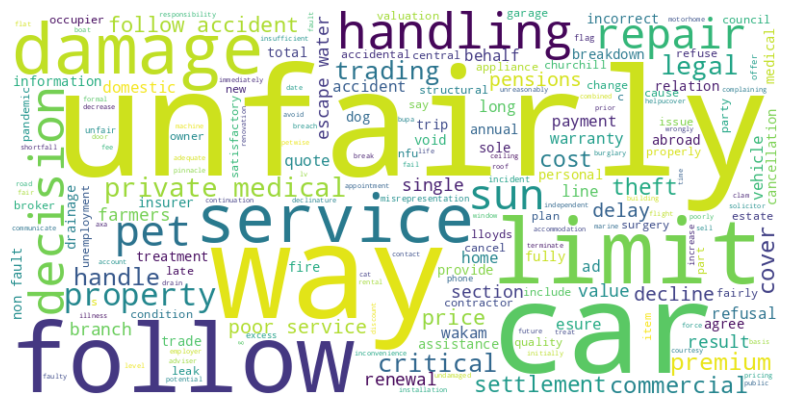

In [18]:
# Replace None values in 'main_reason' with empty strings
df['main_reason'] = df['main_reason'].fillna('')


# Now join all the main reasons into a single string
complain = ' '.join(df['main_reason'])
wordcloud_C = WordCloud(width=800, height=400, background_color='white').generate(complain)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_C, interpolation='bilinear')
plt.axis('off')
plt.show()


**Most Common Words in Cleaned Text** (Exclude Complaint section and final decision section)

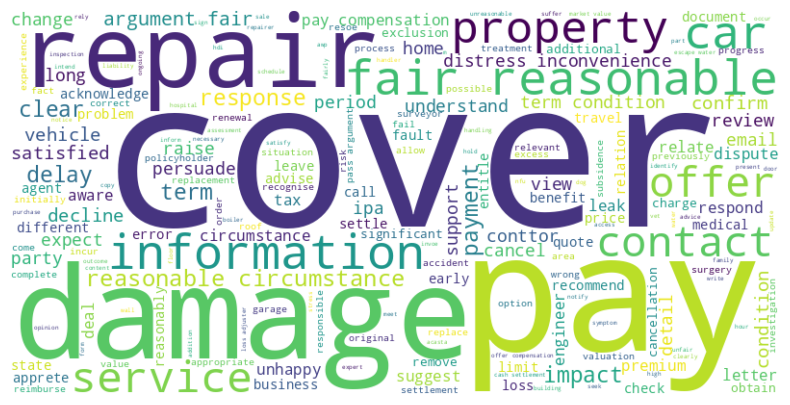

In [19]:
# Word cloud
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

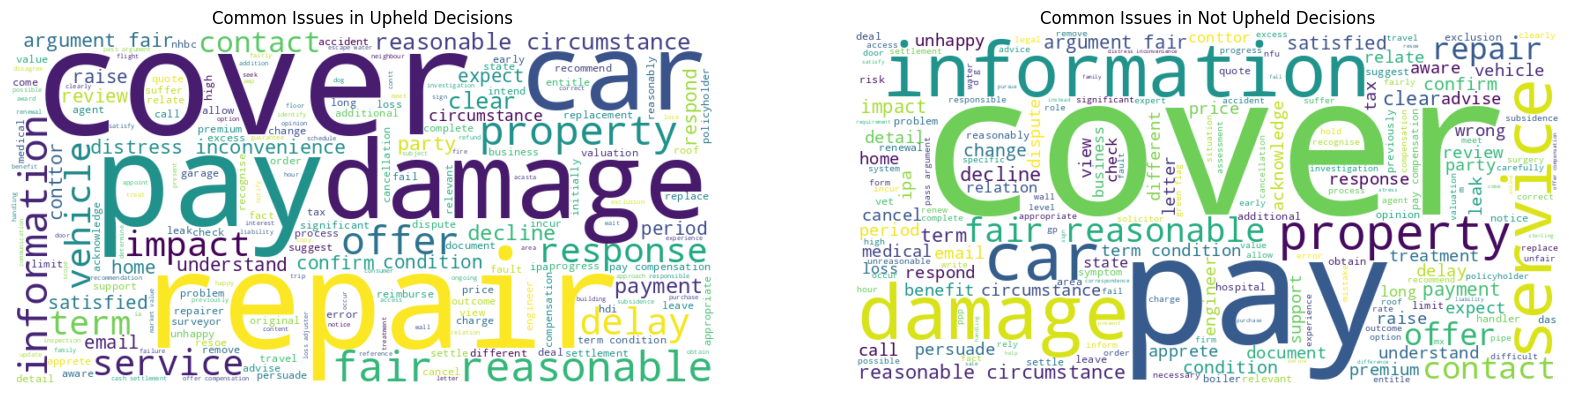

In [20]:
# Explore common words that lead to decisions
def explore_common_word(df):
    # Identify common issues in upheld decisions
    upheld_issues = df[df['decision'] == 'Upheld']['cleaned_text']
    wordcloud_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(upheld_issues))

    # Identify common issues in not upheld decisions
    not_upheld_issues = df[df['decision'] == 'Not upheld']['cleaned_text']
    wordcloud_not_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(not_upheld_issues))

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_upheld, interpolation='bilinear')
    plt.title('Common Issues in Upheld Decisions')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_not_upheld, interpolation='bilinear')
    plt.title('Common Issues in Not Upheld Decisions')
    plt.axis('off')

    plt.show()

explore_common_word(df)

**Product Type**

product_type
car                        110
property                    83
others                      42
travel                      31
health                      23
pet                         20
life                        19
business                    14
legal expenses              13
income                       7
Unknown                      4
buildings                    3
boiler                       2
machine and electronics      1
Name: count, dtype: int64


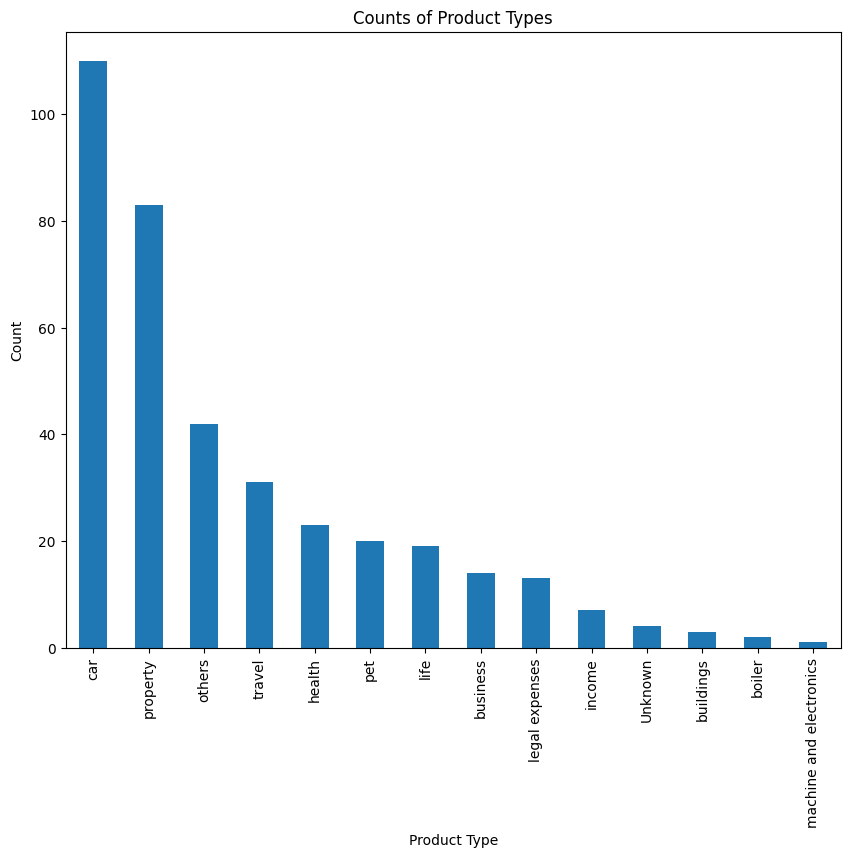

In [21]:
# Known product types for insurance
known_products = {
    'property': r'(property owners|property insurance|home insurance|home emergency|land|house)',
    'buildings': r'(buildings|buildings and contents|flat|apartment)',
    'machine and electronics': r'(appliances|washing machine)',
    'car': r'(car insurance|motor|vehicle)',
    'travel': r'(travel|trip)',
    'health': r'(health|healthcare|disease|medical|surgery|hospital)',
    'life': r'(life|life insurance|life policy|life protection)',
    'pet': r'(pet|dog|petwise|animal)',
    'business': r'(business insurance|business interruption|business)', 
    'income': r'(income|income protection|income insurance)',
    'boiler': r'boiler',
    'emergency': r'(emergency insurance|emergency protection|emergency warranty)',
    'legal expenses': r'(legal advice|legal expenses|legal expense)',
    'others':r'(home|property|burglary)',
}

# Function to extract product type from text
def extract_product_type(text):
    product_types = set()

    # Check for known product types first
    for product, pattern in known_products.items():
        if re.search(pattern, text, re.IGNORECASE):
            product_types.add(product)

    # If multiple product types are detected, return the first match for simplicity
    if len(product_types) > 1:
        product_types = {list(product_types)[0]}
    
    return ', '.join(product_types) if product_types else 'Unknown'

# Function to clean text with synonyms
def clean_text_with_synonyms(text, synonym_mapping, exclude):
    doc = nlp(text)
    tokens = [
        synonym_mapping.get(token.lemma_.lower(), token.lemma_.lower())
        for token in doc
        if len(token.text) > 1
        and not token.is_stop and not token.is_punct
        and not any(char.isdigit() for char in token.text)
        and not re.match(r'^(Mr|Mrs|Miss|Ms)\.?', token.text)
        and token.lemma_.lower() not in exclude
    ]
    return ' '.join(tokens)

# Example synonym mapping
synonym_mapping = {
    "insurance": "insurance",
    "warranty": "insurance",
    "guarantee": "insurance",
}

# Exclusion set for cleaning text
exclude = set(["claim", "policy", "complain", "complains",  "complaint", "complained", "company", "brokers", "decline", "reference",
               "period", "cover", "follow", "service"])

#df['clean_complaint'] = df['complaint_section'].apply(lambda x: remove_company_names(x, company_names))
df['clean_complaint'] = df['complaint_section'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, exclude))
# Apply the extract_product_type function to the DataFrame
df['product_type'] = df['clean_complaint'].apply(extract_product_type)

# Define a function to re-extract product type from cleaned text if initial extraction is 'Unknown'
def re_extract_product_type(row):
    if row['product_type'] == 'Unknown':
        return extract_product_type(row['cleaned_text'])
    return row['product_type']

# Apply the re-extraction function
df['product_type'] = df.apply(re_extract_product_type, axis=1)

# Count occurrences of each product type
product_type_counts = df['product_type'].value_counts()

# Display the counts
print(product_type_counts)

# Plot the counts
plt.figure(figsize=(10, 8))
product_type_counts.plot(kind='bar')
plt.title('Counts of Product Types')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()

Chi-square test statistic: 26.07808670169637
P-value: 0.016595046098894454


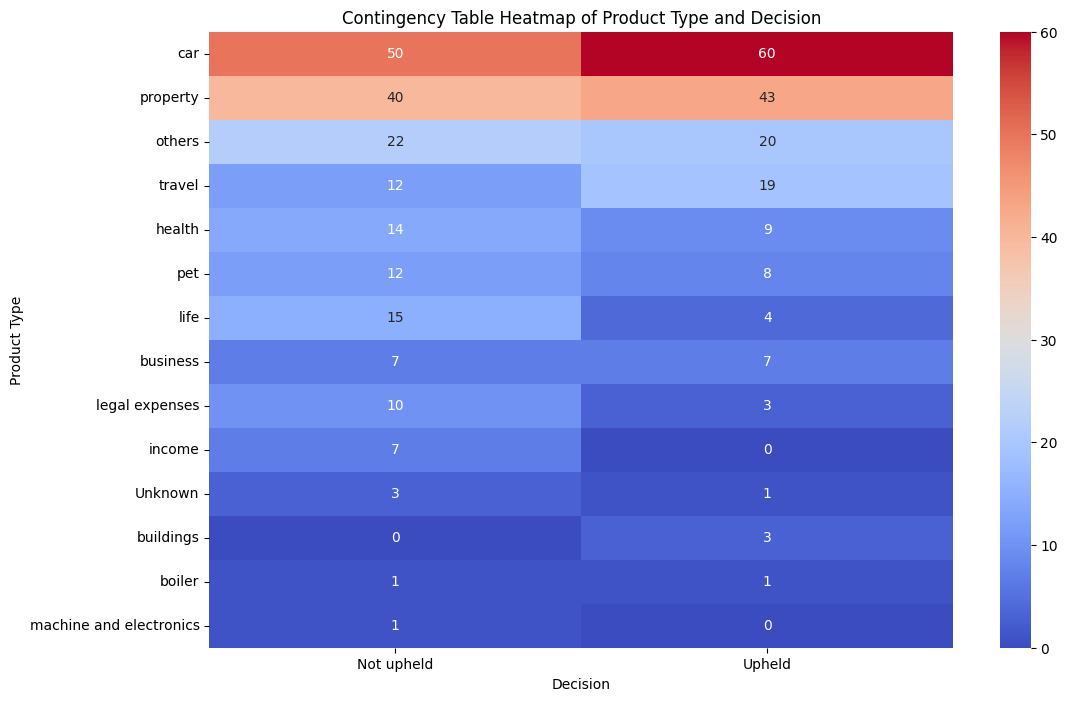

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Assuming your DataFrame is already defined as df and has 'product_type' and 'decision' columns

# Create a contingency table
contingency_table = pd.crosstab(df['product_type'], df['decision'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

# If p-value < 0.05, there is a significant association between product type and decision

# Sort the table by the total of upheld and not upheld decisions
contingency_table['total'] = contingency_table.sum(axis=1)
contingency_table = contingency_table.sort_values(by='total', ascending=False).drop('total', axis=1)
# Plotting the heatmap of the contingency table
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Contingency Table Heatmap of Product Type and Decision')
plt.xlabel('Decision')
plt.ylabel('Product Type')
plt.show()

#### **Interpretation**

**Chi-Square Test and P-value :**

Chi-square test measures how much the observed counts in the contingency table deviate from the expected counts under the null hypothesis of no association. A higher value indicates a greater difference between the observed and expected counts.

The p-value represents the probability of obtaining a chi-square statistic as extreme as, or more extreme than, the observed value under the null hypothesis.
In this case, the p-value is extremely small (essentially zero). This indicates that there is a very low probability that the observed association between product type and decision occurred by chance.

Since the p-value is much smaller than the conventional significance level (e.g., 0.05), we reject the null hypothesis. This means there is a statistically significant association between the product type and the decision outcome (upheld or not upheld)

**Contingency Table**

The analysis reveals that car and property insurance are the most disputed product types, indicating these areas might benefit from improved claims handling processes and clearer policy documentation.
Health and travel insurance also show a significant number of disputes, suggesting these products might need better customer communication and clearer policy terms.
The presence of unknown product types indicates a need for enhanced data processing to ensure all claims are accurately categorized.

**Next to do**
I will keep the words containing all product types like car, home, etc in the features to predict the decision.

**Compensation Amount**

The average compensation across all companies is: £1810.25


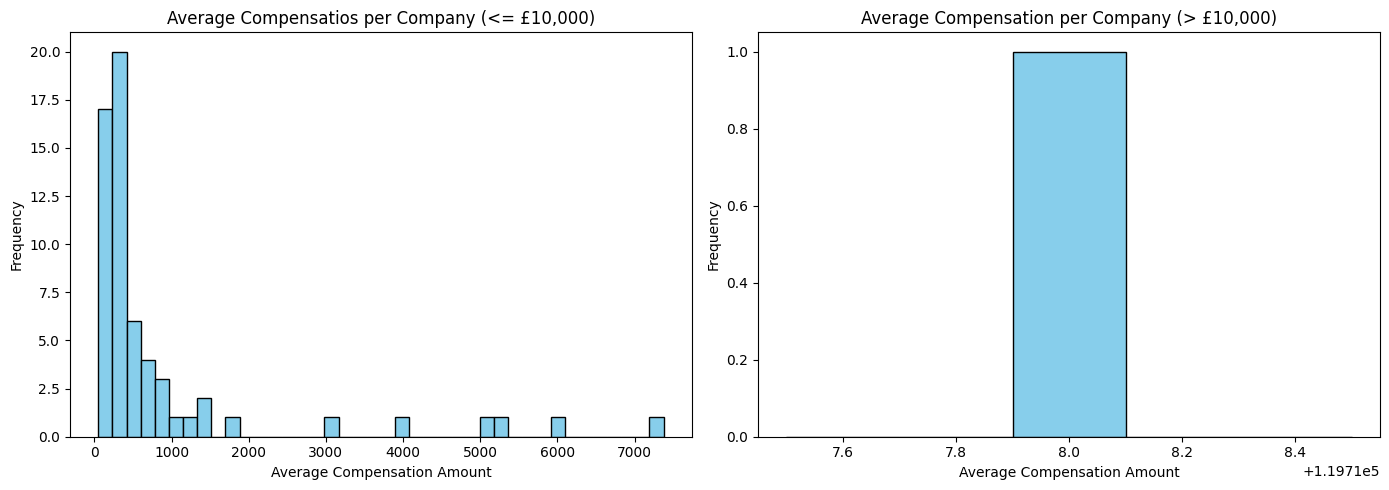

In [23]:
# Function to clean the compensation column
def clean_compensation(comp):
    if isinstance(comp, str):
        # Remove the pound symbol and commas, then strip any whitespace
        comp = comp.replace('£', '').replace(',', '').strip()
        # If the result is empty, replace it with '0'
        if comp == '':
            return 0.0
        # Convert to float
        try:
            return float(comp)
        except ValueError:
            return 0.0
    elif comp is None:
        return 0.0
    return float(comp)

# Apply the cleaning function to the compensation column
df['compensation'] = df['compensation'].apply(clean_compensation)

# Exclude zero compensation amounts
df_nonzero = df[df['compensation'] > 0]

# Calculate the average compensation across all companies
average_compensation_all = df_nonzero['compensation'].mean()

# Display the average compensation
print(f"The average compensation across all companies is: £{average_compensation_all:.2f}")

# Group by company and calculate total and average compensation
company_compensation = df_nonzero.groupby('company')['compensation'].agg(['sum', 'mean', 'count']).reset_index()
company_compensation.columns = ['company', 'total', 'avg', 'count']
company_compensation = company_compensation.sort_values(by='total', ascending=False)

# Split the data into two groups: below and above the threshold
threshold = 10000
below_threshold = company_compensation[company_compensation['avg'] <= threshold]
above_threshold = company_compensation[company_compensation['avg'] > threshold]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot the histogram of average compensation amounts below the threshold
axes[0].hist(below_threshold['avg'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Average Compensation Amount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Average Compensatios per Company (<= £10,000)')

# Plot the histogram of average compensation amounts above the threshold
axes[1].hist(above_threshold['avg'], bins=5, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Average Compensation Amount')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Average Compensation per Company (> £10,000)')

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
# Filter companies with average compensation above the threshold
extreme_companies = company_compensation[company_compensation['avg'] > threshold]

# Filter companies with average compensation above the threshold
not_extreme_companies = company_compensation[company_compensation['avg'] <= threshold]

# Display the companies with extreme compensation amounts
print(f' company with extreme compensation amount : ')
print(extreme_companies)

 company with extreme compensation amount : 
                                 company     total       avg  count
25  ERGO Versicherung Aktiengesellschaft  119718.0  119718.0      1


### 4. Visualization of Trends
This involves visualisation of data distributions, outlier
identification, and other interesting insights coming from the dataset

decision
Not upheld    194
Upheld        178
Name: count, dtype: int64


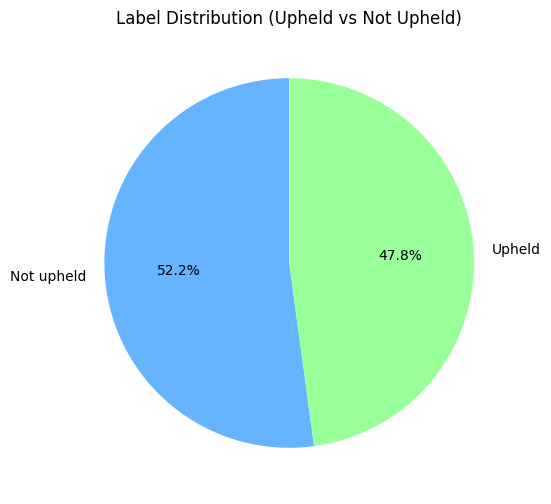

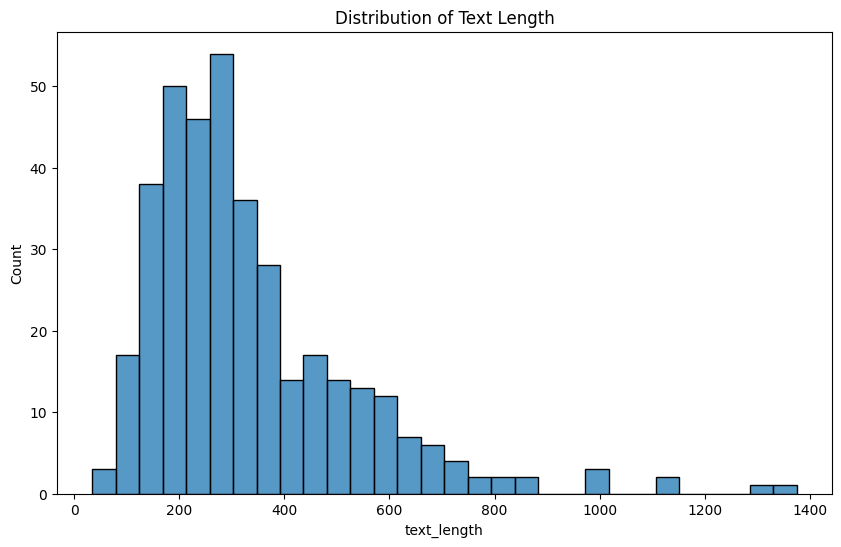

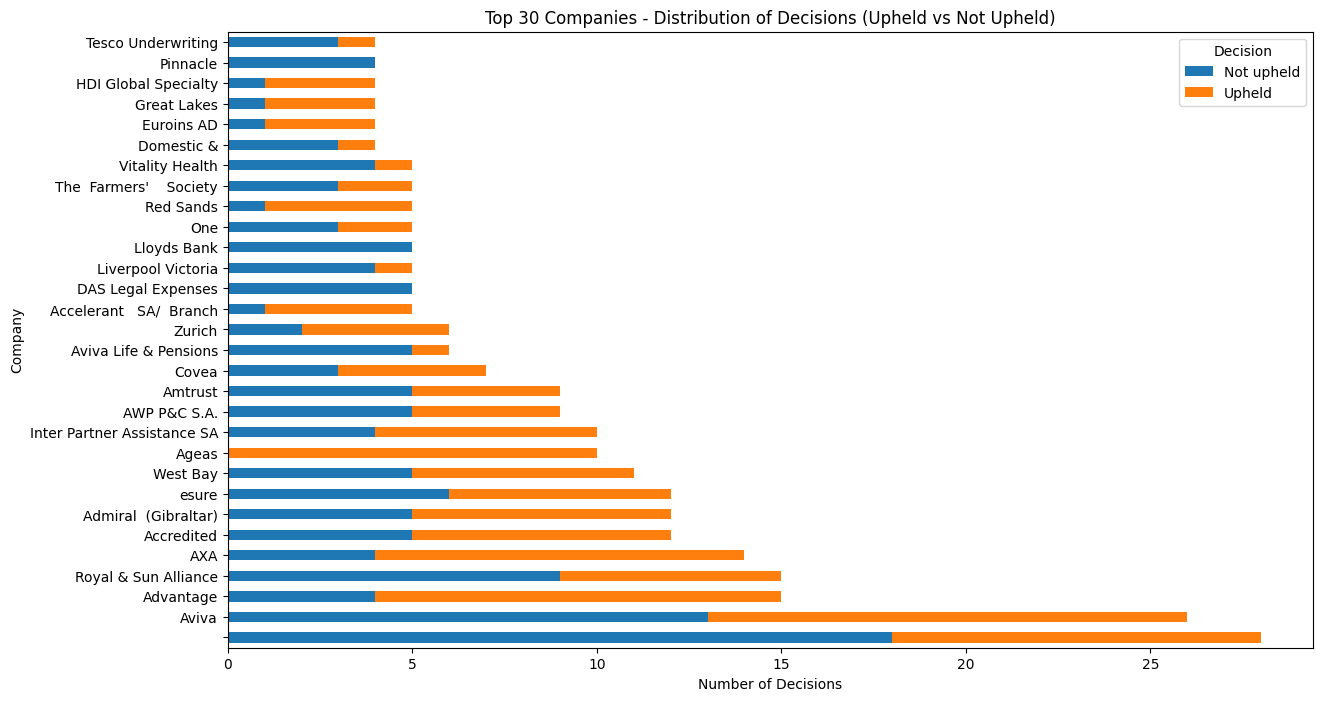

In [25]:
# Basic statistics
print(df['decision'].value_counts())

# Visualize the label distribution with a pie chart
plt.figure(figsize=(8, 6))
df['decision'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution (Upheld vs Not Upheld)')
plt.ylabel('')  # Hide the y-label for better appearance
plt.show()

# Length of text analysis
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30)
plt.title('Distribution of Text Length')
plt.show()

# Aggregate decision counts by company
company_decision_counts = df.groupby(['company', 'decision']).size().unstack().fillna(0)

# Select the top 30 companies based on the total number of decisions
top_30_companies = company_decision_counts.sum(axis=1).nlargest(30).index
top_30_decision_counts = company_decision_counts.loc[top_30_companies]

# Plot stacked horizontal bar chart
top_30_decision_counts.plot(kind='barh', stacked=True, figsize=(14, 8))

plt.ylabel('Company')
plt.xlabel('Number of Decisions')
plt.title('Top 30 Companies - Distribution of Decisions (Upheld vs Not Upheld)')
plt.legend(title='Decision', loc='upper right')
plt.show()

In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Assuming df is your DataFrame and it has the columns 'company' and 'decision'

# Convert the decision column to binary values
df['decision_binary'] = df['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

# One-hot encode the company column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
company_encoded = encoder.fit_transform(df[['company']])

# Create a DataFrame for the encoded company data
company_encoded_df = pd.DataFrame(company_encoded, columns=encoder.get_feature_names_out(['company']))

# Add the decision_binary column to the encoded company DataFrame
company_encoded_df['decision_binary'] = df['decision_binary'].values

# Compute the correlation matrix
correlation_matrix = company_encoded_df.corr()

# Extract the correlations with the decision_binary column
correlations_with_decision = correlation_matrix['decision_binary'].drop('decision_binary')

# Sort the correlations to see the most and least correlated companies
sorted_correlations = correlations_with_decision.sort_values(ascending=False)

# Display the top correlated companies
print("Top correlated companies with decision outcome (upheld):")
print(sorted_correlations.head(10))

# Display the bottom correlated companies
print("\nLeast correlated companies with decision outcome (upheld):")
print(sorted_correlations.tail(10))

Top correlated companies with decision outcome (upheld):
company_Ageas                        0.173515
company_Wakam                        0.108842
company_Advantage                    0.104570
company_Casualty &                   0.094132
company_Helvetia Global Solutions    0.094132
company_AXA                          0.093343
company_House-Building Council       0.076755
company_Haven                        0.076755
company_AA Underwriting              0.076755
company_Accelerant   SA/  Branch     0.075123
Name: decision_binary, dtype: float64

Least correlated companies with decision outcome (upheld):
company_Hiscox                  -0.070424
company_BISL                    -0.070424
company_AXA PPP Healthcare      -0.070424
company_Aviva Life & Pensions   -0.079925
company_Unum                    -0.086369
company_Fairmead                -0.086369
company_BUPA                    -0.086369
company_Pinnacle                -0.099865
company_Lloyds Bank             -0.111805
company

Note : The correlation values are relatively low, indicating a weak but noticeable trend. Therefore, I will not include the company name in the features.

### 5. Text transformation and Split data 

In [27]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['decision']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Prediction of Claim Outcome with Hyperparameter Tuning

#### A. Logistic Regression Model

In [28]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [10, 50, 100, 150]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV] END ...............................................C=10; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ..............................................C=100; total time=   0.0s
[CV] END ..............................................C=100; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [10, 50, 100, 150]}, verbose=2)

In [29]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 10}
Logistic Regression Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.67      0.78      0.72        36
      Upheld       0.76      0.64      0.69        39

    accuracy                           0.71        75
   macro avg       0.71      0.71      0.71        75
weighted avg       0.71      0.71      0.71        75

[[28  8]
 [14 25]]


#### B. Decision Tree Model

In [30]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.0s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=10, min_sam

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [31]:
# Best parameters from GridSearchCV for Decision Tree
print("Best parameters for Decision Tree:", grid_dt.best_params_)

# Predictions and evaluation for Decision Tree
y_pred_dt = grid_dt.predict(X_test)
print("Decision Tree Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}
Decision Tree Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.69      0.67      0.68        36
      Upheld       0.70      0.72      0.71        39

    accuracy                           0.69        75
   macro avg       0.69      0.69      0.69        75
weighted avg       0.69      0.69      0.69        75

[[24 12]
 [11 28]]


#### C. Random Forest Model

In [32]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [200, 300, 400], 'max_features': ['auto', 'sqrt']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=400; total time=   0.0s
[CV] END ................max_features=auto, n_est

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/c

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 300, 400]},
             verbose=2)

In [33]:
# Best parameters from GridSearchCV for Random Forest
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Predictions and evaluation for Random Forest
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 300}
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.69      0.81      0.74        36
      Upheld       0.79      0.67      0.72        39

    accuracy                           0.73        75
   macro avg       0.74      0.74      0.73        75
weighted avg       0.74      0.73      0.73        75

[[29  7]
 [13 26]]


### 7. Feature Importance

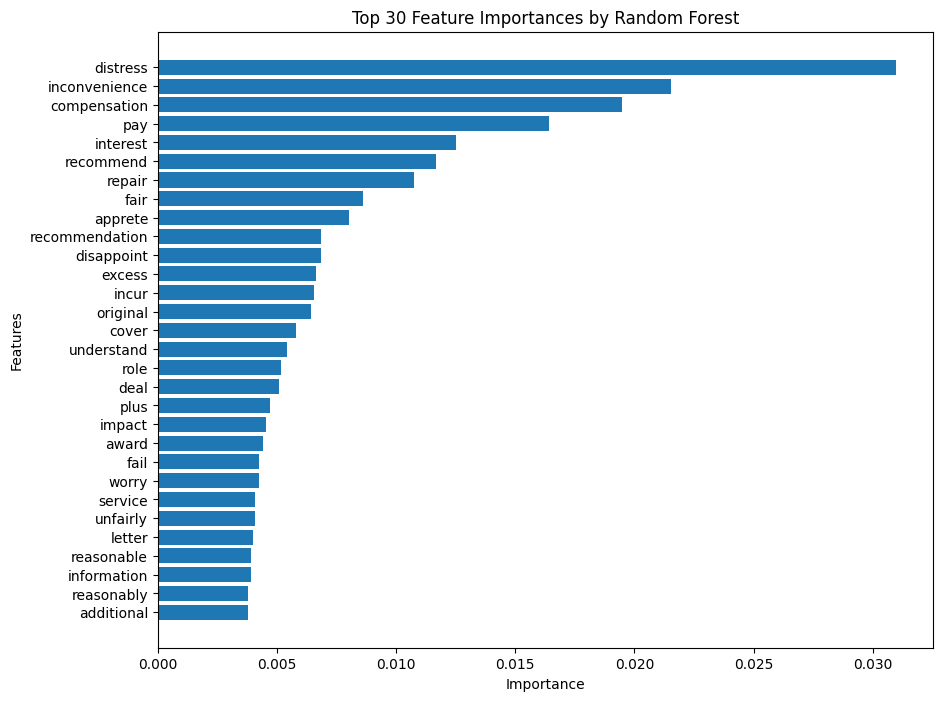

In [34]:
# Assuming the feature importance plot data is available
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Get top 20 features
top_features = [features[i] for i in indices[:30]]
top_importances = [importances[i] for i in indices[:30]]

# Create a DataFrame to map features and their importances
feature_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances by Random Forest")
plt.barh(range(len(top_features)), top_importances, align="center")
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()

In [35]:
def get_synonym_group(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def group_features_by_synonyms(features):
    grouped_features = {}
    for feature in features:
        synonyms = get_synonym_group(feature)
        found_group = False
        for group in grouped_features:
            if not synonyms.isdisjoint(grouped_features[group]):
                grouped_features[group].update(synonyms)
                grouped_features[group].add(feature)
                found_group = True
                break
        if not found_group:
            grouped_features[feature] = synonyms
            grouped_features[feature].add(feature)
    return grouped_features

# Assuming the feature importance plot data is available
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Get top 20 features
top_features = [features[i] for i in indices[:30]]

# Group features by synonyms
grouped_features = group_features_by_synonyms(top_features)

# Print grouped features
for key, value in grouped_features.items():
    print(f"{key}: {', '.join(value)}")

distress: straiten, distraint, distress, hurt, suffering
inconvenience: trouble, care, disoblige, concern, discommode, bother, incommode, troublesomeness, inconvenience, worriment, incommodiousness, vexation, put_out, headache, interest, worry, occupy, vex
compensation: shock, deal, bear_upon, recreate, back, mete_out, care, softwood, make_out, get_by, wad, top, binding, rectify, hand, flock, pot, animate, pile, revive, book_binding, cope, get_across, brood, manage, share, dole_out, reparation, impact, doctor, covering_fire, breed, heap, fix, stack, comprehend, business_deal, vivify, carry_on, good_deal, treat, restore, traverse, compensate, overlay, conduct, allot, cut_across, haunt, cross, reanimate, quicken, resort, screening, embrace, peck, hide, dispense, deal_out, track, mickle, compensation, shell_out, hangout, cover_song, grapple, enshroud, slew, address, take, portion_out, tidy_sum, spate, touch, revivify, plenty, remediate, impingement, quite_a_little, cover_charge, natural_c

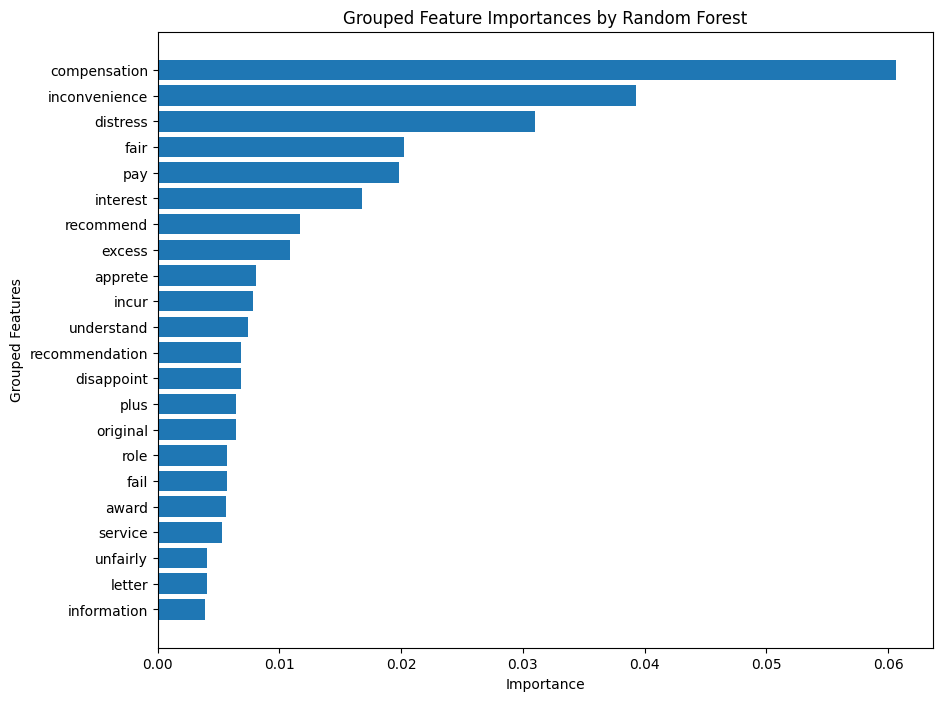

In [36]:
# Aggregate importances for grouped features
grouped_importances = defaultdict(float)
for feature, synonyms in grouped_features.items():
    for synonym in synonyms:
        if synonym in features:
            idx = list(features).index(synonym)
            grouped_importances[feature] += importances[idx]

# Sort grouped features by their aggregated importance
sorted_grouped_importances = sorted(grouped_importances.items(), key=lambda x: x[1], reverse=True)

# Plot grouped feature importances
plt.figure(figsize=(10, 8))
plt.title("Grouped Feature Importances by Random Forest")
plt.barh(range(len(sorted_grouped_importances)), [importance for _, importance in sorted_grouped_importances], align="center")
plt.yticks(range(len(sorted_grouped_importances)), [feature for feature, _ in sorted_grouped_importances])
plt.xlabel('Importance')
plt.ylabel('Grouped Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()


>> to do : Analyze Feature Importance for Decision Making

**Guide Decision Making on Products**

/tmp/ipykernel_83378/1947693130.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Product Type', data=product_type_importance_df, palette='viridis')


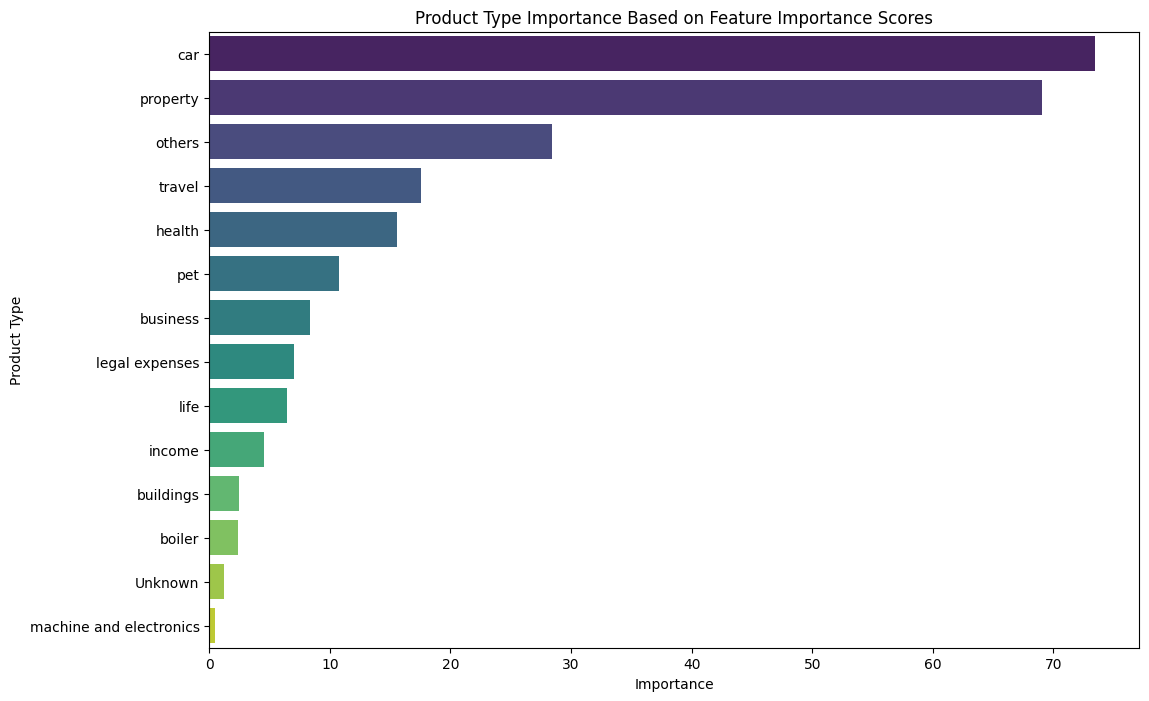

In [37]:
# Assuming the Random Forest model and vectorizer are already trained
importances = grid_rf.best_estimator_.feature_importances_
features = vectorizer.get_feature_names_out()

# Get the feature importance dictionary
feature_importance_dict = dict(zip(features, importances))

# Function to calculate weighted product type importance
def calculate_product_type_importance(df, feature_importance_dict):
    product_type_importance = defaultdict(float)
    for idx, row in df.iterrows():
        product_types = row['product_type'].split(', ')
        cleaned_text = row['cleaned_text']
        for product in product_types:
            for word in cleaned_text.split():
                if word in feature_importance_dict:
                    product_type_importance[product] += feature_importance_dict[word]
    return product_type_importance

# Calculate the importance of each product type
product_type_importance = calculate_product_type_importance(df, feature_importance_dict)

# Convert to DataFrame for plotting
product_type_importance_df = pd.DataFrame(list(product_type_importance.items()), columns=['Product Type', 'Importance'])
product_type_importance_df = product_type_importance_df.sort_values(by='Importance', ascending=False)

# Plot the distribution of product types by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Product Type', data=product_type_importance_df, palette='viridis')
plt.title('Product Type Importance Based on Feature Importance Scores')
plt.xlabel('Importance')
plt.ylabel('Product Type')
plt.show()


### Interpreting the Product Type Importance Plot

The bar plot titled **"Product Type Importance Based on Feature Importance Scores"** visualizes the relative importance of different product types in influencing the decision outcomes (upheld or not upheld). Here's a step-by-step interpretation:

1. **Overall Importance**: 
   - The plot ranks product types based on their importance scores. The higher the score, the more significant the product type is in determining the decision outcome.
   - The length of each bar represents the cumulative importance score of features associated with each product type.

2. **Top Product Types**:
   - **Car Insurance**: This product type has the highest importance score, suggesting that features associated with car insurance claims significantly impact the decision outcomes. This could indicate a high volume of car insurance-related complaints or more complex cases requiring detailed adjudication.
   - **Property Insurance**: Property insurance follows closely behind car insurance in importance. This suggests that property-related claims also play a significant role in decision outcomes.
   - **Travel Insurance**: Travel insurance is another critical product type influencing decision outcomes. 

3. **Mid-Range Product Types**:
   - **Others, Life, Health, Business, Pet**: These product types have moderate importance scores. While they are not as influential as car or property insurance, they still play a notable role in the decision-making process.
   - **Legal Expenses, Buildings, Income**: These types are important but to a lesser extent compared to the top and mid-range categories.

4. **Lower Importance Product Types**:
   - **Boiler Insurance** and **Machine and Electronics Insurance**: These product types have the lowest importance scores, indicating that they are less frequently involved in decisions or have less complex cases.

### Practical Implications:

1. **Product Development**:
   - **Car Insurance**: Given its high importance, consider enhancing car insurance products, adding features that address common complaints or improving claim handling processes.
   - **Property and Travel Insurance**: Similarly, focus on these areas to innovate and reduce complaint rates.

#### Minimize Future Disputes and Enhance Customer Satisfaction
Predict and prevent potential disputes by addressing issues before they escalate.

In [38]:
# Predict using the Random Forest model
predictions = grid_rf.predict(X)

# Add predictions to the DataFrame
df['predictions'] = predictions

# Analyze predictions for insights
upheld_predictions = df[df['predictions'] == 'Upheld']
not_upheld_predictions = df[df['predictions'] == 'Not upheld']

print("Predictions for Upheld Complaints:", upheld_predictions.shape[0])
print("Predictions for Not Upheld Complaints:", not_upheld_predictions.shape[0])

Predictions for Upheld Complaints: 172
Predictions for Not Upheld Complaints: 200


#### Visualize and Communicate Findings
Use visualizations to communicate the key findings to stakeholders.

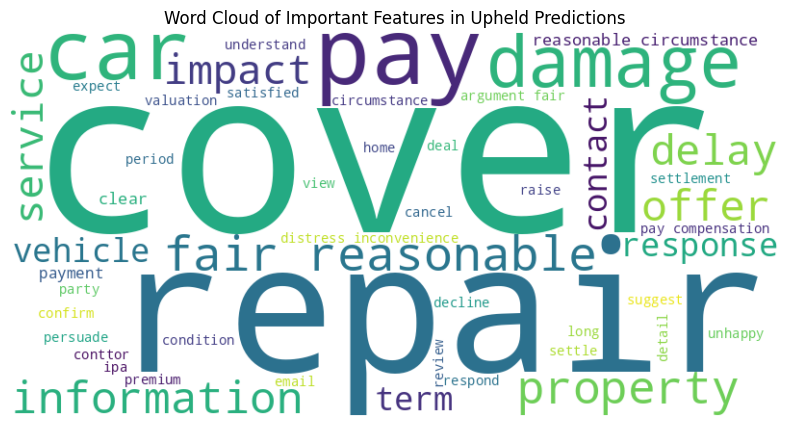

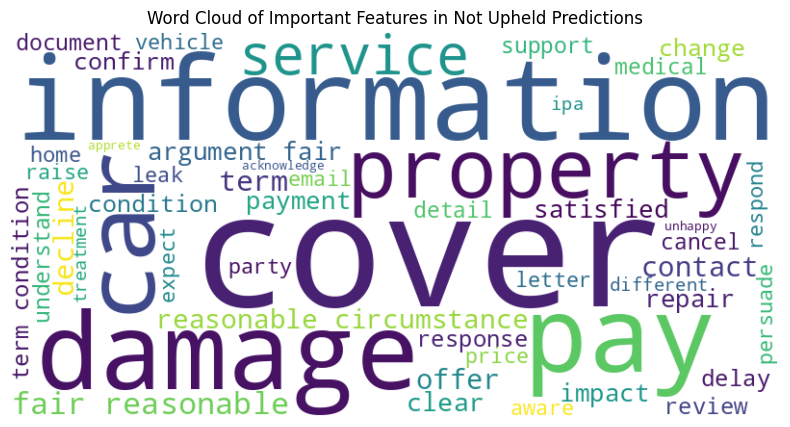

In [39]:
# Function to generate a word cloud from text data
def generate_wordcloud_from_text(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to generate word clouds for important features based on predictions
def generate_wordclouds_based_on_predictions(df, importances, features):
    # Filter the data based on predictions
    upheld_text = ' '.join(df[df['predictions'] == 'Upheld']['cleaned_text'])
    not_upheld_text = ' '.join(df[df['predictions'] == 'Not upheld']['cleaned_text'])
    
    # Generate word clouds
    generate_wordcloud_from_text(upheld_text, 'Word Cloud of Important Features in Upheld Predictions')
    generate_wordcloud_from_text(not_upheld_text, 'Word Cloud of Important Features in Not Upheld Predictions')

# Assuming `importances` contains the feature importance scores
# and `vectorizer` is the fitted vectorizer used for feature extraction
features = vectorizer.get_feature_names_out()
importances = grid_rf.best_estimator_.feature_importances_

# Generate and plot word clouds for the important features in upheld and not upheld decisions
generate_wordclouds_based_on_predictions(df, importances, features)
